In [1]:
# copy the lib file in the working directory and load it
from shutil import copyfile
copyfile('target/release/libising.so', 'ising.so')
import ising

In [2]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import threading
import time

In [3]:
L = 24

k_ijl = [(i,j,l) for j in range(2*L) for i in range(2*L) for l in range(3) if (i+j > L-2) and (i+j < 3*L-1)]
ijl_k = {}
for k, ijl in enumerate(k_ijl):
    ijl_k[ijl] = k

In [4]:
A = [[(0,0), (0,0), (-1,0), (0,-1)], 
     [(1,-1), (1,0), (0,0), (0,0)], 
     [(0,1), (-1,1), (0,0), (0,0)]]
B = [[1, 2, 1, 2], [2, 0, 2, 0], [0, 1, 0, 1]]

nn1 = [[(i + A[l][u][0], j + A[l][u][1], B[l][u]) for u in range(4)] for (i,j,l) in k_ijl]

A = [[(-1, 1), (-1, 0), (0, -1), (1, -1)],
     [(0, -1), (1, -1), (1, 0), (0, 1)],
     [(1, 0), (0, 1), (-1, 1), (-1, 0)]]
B = [[1, 2, 1, 2], [2, 0, 2, 0], [0, 1, 0, 1]]

nn2 = [[(i + A[l][u][0], j + A[l][u][1], B[l][u]) for u in range(4)] for (i,j,l) in k_ijl]

# fixing periodic border conditions 
def foo(i, j, l):
    if i == 2*L:
        i = 0
        j += L
    if j == 2*L:
        i += L
        j = 0
    if i+j == L-2:
        i += L
        j += L
    if i+j == 3*L-1:
        i -= L
        j -= L
    if j == -1:
        i -= L
        j = 2*L-1
    if i == -1:
        i = 2*L-1
        j -= L
    return (i, j, l)

nn1 = [[ijl_k[foo(i,j,l)] for (i,j,l) in n] for n in nn1]
nn2 = [[ijl_k[foo(i,j,l)] for (i,j,l) in n] for n in nn2]

In [5]:
H = ising.Hamiltonian([(-1, nn1), (1, nn2)])

In [6]:
n = 100  # amount of temperatures / states

# Initialize the states, compute the enegies and attribute their temperatures
xs = [(np.random.randint(0, 2, size=(9 * L * L,), dtype=np.int32) * 2 - 1) for i in range(n)]
es = [H.energy(xs[i]) for i in range(n)]

bs = np.linspace(0.01, 2, n)
ts = 1 / bs

<IPython.core.display.Javascript object>


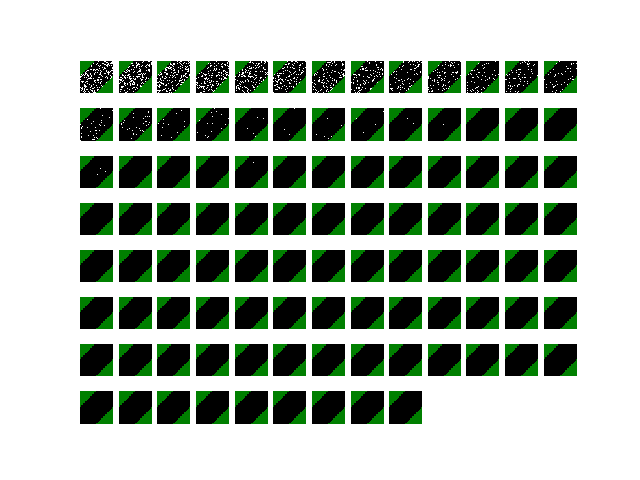

In [7]:
# This cell only makes a plot to show the evolutions of the states in real time

# compute the appropriate amount of plots to do in width
w = int(np.ceil(np.sqrt(1.5 * n)))

# create a new figure and its subplots
fig = plt.figure()
axes = [fig.add_subplot(int(np.ceil(n / w)), w, i + 1) for i in range(n)]

def image(x):
    z = np.zeros((2*L, 2*L, 3))
    z[:,:] = [0, 0.5, 0]
    for i in range(2 * L):
        for j in range(2 * L):
            if (i,j,0) in ijl_k:
                v0 = x[ijl_k[(i, j, 0)]]
                v1 = x[ijl_k[(i, j, 1)]]
                v2 = x[ijl_k[(i, j, 2)]]
                z[j, i] = 1 if v0 == v1 and v1 == v2 else 0
    return z

def plot(i):
    axes[i].set_axis_off()
    return axes[i].imshow(image(xs[i]), vmin=-1, vmax=1)

imgs = [plot(i) for i in range(n)]

fig.canvas.draw()

# this function sets the new data into the figure and redraw it
def replot(xs):
    for i in range(n):
        imgs[i].set_data(image(xs[i]))
    fig.canvas.draw()

In [8]:
# for debug purpose, this function measure the execution time of a portion of code

def top(text=None):
    now = time.time()
    if text:
        print("{} : {:.3f}s".format(text, now - top.past))
    top.past = now
    
top.past = time.time()

In [9]:
# Define a function that perform sweep in parallel then do parallel tempering

def sweep_swap():
    num_threads = 4
    
    # create and run one thread for each temperature
    threads = []
    for i in range(num_threads):
        # define the function that will be run by the thread (it depends on the value of i)
        def sweep():
            # perform a sweep on the states i, i+num_threads, i+2*num_threads, ...
            for j in range(i, n, num_threads):
                es[j] += H.sweep(xs[j], ts[j]) # the sweep returns the delta in energy
        
        t = threading.Thread(target=sweep) # create a new thread
        t.start() # start it
        threads.append(t)

    # wait all threads to finish
    for t in threads:
        t.join()

    # performs swaps
    for _ in range(2 * n):
        #[i, j] = np.random.choice(n, 2, replace=False) # pick randomly i != j
        i = np.random.randint(n - 1)
        j = i + 1
        if np.random.uniform() < np.exp((es[i] - es[j]) * (bs[i] - bs[j])):
            # swap the states and the energies
            xs[i], xs[j] = xs[j], xs[i]
            es[i], es[j] = es[j], es[i]

In [10]:
top()
# thermalize
for _ in range(200):
    sweep_swap()

top('termalize')

replot(xs)

termalize : 5.063s


In [11]:
m = 2000
energy = np.zeros((m, n))
magnet = np.zeros((m, n))

for i in range(m):
    top()
    
    sweep_swap()
    energy[i] = np.array(es) / (9 * L * L)
    magnet[i] = np.array([np.sum(xs[j]) for j in range(n)]) / (9 * L * L)
    
    top(str(i))
    
    if i % 50 == 0:
        replot(xs)
        top('plot')

0 : 0.037s
plot : 0.329s
1 : 0.045s
2 : 0.033s
3 : 0.031s
4 : 0.024s
5 : 0.023s
6 : 0.025s
7 : 0.033s
8 : 0.036s
9 : 0.033s
10 : 0.030s
11 : 0.024s
12 : 0.024s
13 : 0.024s
14 : 0.030s
15 : 0.040s
16 : 0.037s
17 : 0.032s
18 : 0.027s
19 : 0.027s
20 : 0.031s
21 : 0.043s
22 : 0.027s
23 : 0.028s
24 : 0.024s
25 : 0.030s
26 : 0.024s
27 : 0.030s
28 : 0.027s
29 : 0.033s
30 : 0.036s
31 : 0.028s
32 : 0.033s
33 : 0.028s
34 : 0.029s
35 : 0.027s
36 : 0.026s
37 : 0.043s
38 : 0.024s
39 : 0.026s
40 : 0.025s
41 : 0.026s
42 : 0.024s
43 : 0.024s
44 : 0.035s
45 : 0.028s
46 : 0.024s
47 : 0.025s
48 : 0.030s
49 : 0.024s
50 : 0.024s
plot : 0.325s
51 : 0.045s
52 : 0.025s
53 : 0.026s
54 : 0.030s
55 : 0.024s
56 : 0.025s
57 : 0.024s
58 : 0.041s
59 : 0.038s
60 : 0.033s
61 : 0.031s
62 : 0.024s
63 : 0.025s
64 : 0.025s
65 : 0.028s
66 : 0.042s
67 : 0.028s
68 : 0.031s
69 : 0.030s
70 : 0.027s
71 : 0.030s
72 : 0.035s
73 : 0.029s
74 : 0.030s
75 : 0.024s
76 : 0.025s
77 : 0.024s
78 : 0.031s
79 : 0.025s
80 : 0.035s
81 : 0.031

<IPython.core.display.Javascript object>


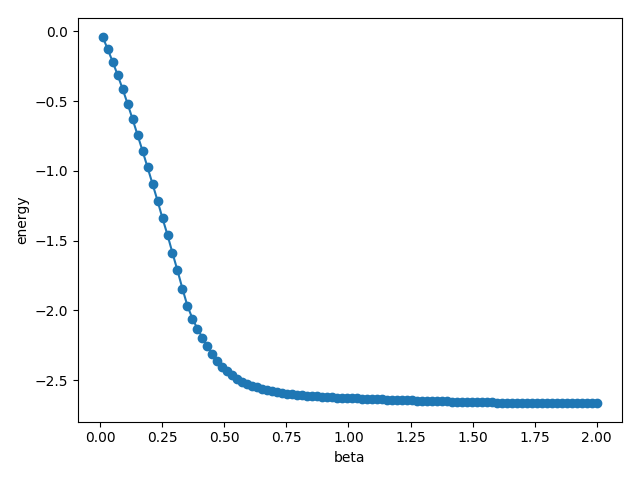

In [12]:
plt.figure()
plt.plot(bs, np.mean(energy, 0), 'o-')
plt.xlabel('beta')
plt.ylabel('energy')
plt.tight_layout()

<IPython.core.display.Javascript object>


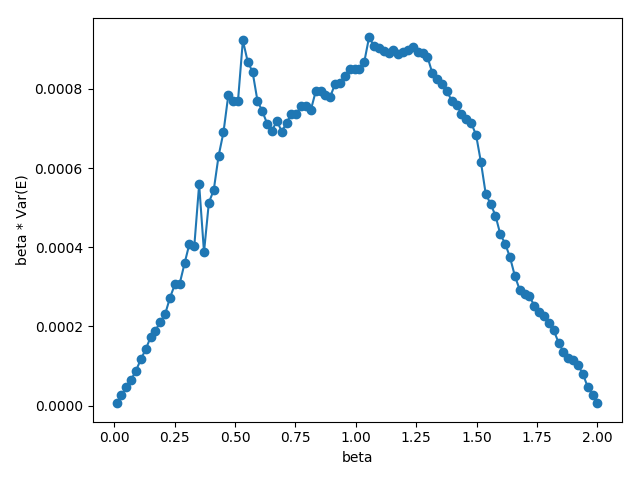

In [13]:
plt.figure()
plt.plot(bs, bs * np.var(energy, 0), 'o-')
plt.xlabel('beta')
plt.ylabel('beta * Var(E)')
plt.tight_layout()

In [14]:
np.log(2) - np.trapz(bs * np.var(energy, 0), bs) * (9 * L * L)

-5.0613776665778119

<IPython.core.display.Javascript object>


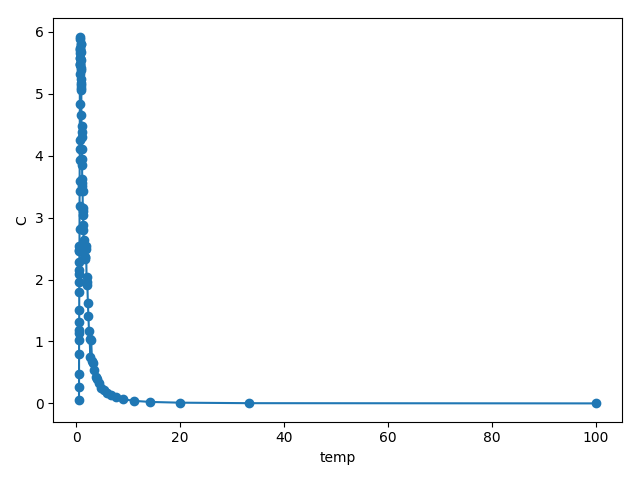

In [15]:
plt.figure()
plt.plot(ts, np.var(energy, 0) * (9 * L * L) / ts**2, 'o-')
plt.xlabel('temp')
plt.ylabel('C')
plt.tight_layout()

In [16]:
np.mean(energy, 0)

array([-0.03979205, -0.12653627, -0.21730903, -0.31245718, -0.41249344,
       -0.51896026, -0.62937307, -0.74304823, -0.85719715, -0.97469637,
       -1.09406906, -1.21370332, -1.34066319, -1.45945062, -1.58943827,
       -1.71413812, -1.84553549, -1.96834722, -2.05910147, -2.1323939 ,
       -2.19566281, -2.25861034, -2.31490779, -2.36311613, -2.40492593,
       -2.43731173, -2.46554977, -2.49099421, -2.51125463, -2.52702585,
       -2.54039583, -2.55164198, -2.56088349, -2.57057562, -2.57863349,
       -2.58543711, -2.59177122, -2.59654938, -2.60105941, -2.60461458,
       -2.60803125, -2.61198457, -2.61426813, -2.61680556, -2.6188723 ,
       -2.62174961, -2.62395409, -2.62537577, -2.62699267, -2.62813657,
       -2.62943557, -2.63102739, -2.63452546, -2.63579823, -2.63658989,
       -2.63738542, -2.63801119, -2.63921991, -2.64021103, -2.64103279,
       -2.64275309, -2.64360532, -2.64408565, -2.6459892 , -2.64689931,
       -2.64772994, -2.64828048, -2.64951698, -2.65154012, -2.65